# Here starts the eval script with debugging

In [4]:
import argparse
import copy
import math
import sys,os
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm
import flows as fnn

from eval_model import eval_model
from data_loader import load_dataset, load_data # detta är från en separat fil, data_loader.py

In [5]:
innermodel="inner_withsig_epoch_9_Model.par"
outermodel="outer_withsig_epoch_9_Model.par"
datashift=0

# model parameters
flow='maf'
num_blocks = 15
num_hidden = 128
lr = 1e-4

print('MAF pars',num_blocks,num_hidden)

MAF pars 15 128


In [6]:
CUDA = False
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}

# panda läser h5-filer
features_sig=pd.read_hdf("LHCORD_sig_features.h5")
features_bg=pd.read_hdf("LHCORD_qcd_features.h5")

# load_data definieras i data_loader.py och returnerar följande:
# np.dstack((mjj/1000,mjmin/1000,(mjmax-mjmin)/1000,tau21min,tau21max))[0]
# Dvs, en vektor [mjj/1000,mj1/1000,(mj2-mj1)/1000,tau21J1,tau21J2]

# laddar in bakgrund och lägger till nollor på slutet av varje event, 
# för att markera det som bakgrund
dataset_bg=load_data(features_bg)
dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1)))) 

# laddar in signal och lägger till ettor på slutet av varje event, 
# för att markera det som signal
dataset_sig=load_data(features_sig)
dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

# Concatenates signal events to background events
dataset=np.concatenate((dataset_bg[:500000],dataset_sig[:500])).astype('float32') 
dataset_test=np.concatenate((dataset_bg[500000:],dataset_sig[500:])).astype('float32') 
dataset_test_actual=np.concatenate((dataset_bg[500000:],dataset_sig[500:1000])).astype('float32') 

dataset_shifted=np.copy(dataset)
dataset_shifted[:,1]=dataset_shifted[:,1]+datashift*(dataset_shifted[:,0]-3.5)
dataset_shifted[:,2]=dataset_shifted[:,2]+datashift*(dataset_shifted[:,0]-3.5)

dataset_test_shifted=np.copy(dataset_test)
dataset_test_shifted[:,1]=dataset_test_shifted[:,1]+datashift*(dataset_test_shifted[:,0]-3.5)
dataset_test_shifted[:,2]=dataset_test_shifted[:,2]+datashift*(dataset_test_shifted[:,0]-3.5)

dataset_test_actual_shifted=np.copy(dataset_test_actual)
dataset_test_actual_shifted[:,1]=dataset_test_actual_shifted[:,1]+datashift*(dataset_test_actual_shifted[:,0]-3.5)
dataset_test_actual_shifted[:,2]=dataset_test_actual_shifted[:,2]+datashift*(dataset_test_actual_shifted[:,0]-3.5)

traindict=load_dataset(dataset_shifted)
testdict=load_dataset(dataset_test_shifted)
testdict_actual=load_dataset(dataset_test_actual_shifted)

flow='maf'
num_blocks = 15
num_hidden = 128
lr = 1e-4
num_inputs = traindict['all_tensor'].shape[-1]
num_cond_inputs = traindict['all_labels'].shape[-1]  # labels are conditional data


CUDA = False
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}

[391, 60984, 0.006411517775154139, 1.5833203876933022]
[74907, 60368, 1.2408395176252318, 304.87303217364644]
[381, 60368, 0.006311290750066261, 1.5506778439686448]


In [8]:
# Define model
act = 'relu'

modules = []
for _ in range(num_blocks):
    modules += [
        fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
        fnn.BatchNormFlow(num_inputs),
        fnn.Reverse(num_inputs)
    ]

outer_model = fnn.FlowSequential(*modules)
for module in outer_model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)
outer_model.to(device)
            

modules = []
for _ in range(num_blocks):
    modules += [
        fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
        fnn.BatchNormFlow(num_inputs),
        fnn.Reverse(num_inputs)
    ]

    
inner_model = fnn.FlowSequential(*modules)
for module in inner_model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)
inner_model.to(device)


print()

#latest_run="runs/Dec02_01-40-38_pascal.physics.rutgers.edumaf_LHCORD" #run with logit and standardization, using inner, larger network, SHIFTED DATASET

outer_model.load_state_dict(torch.load(outermodel, map_location='cpu'))
inner_model.load_state_dict(torch.load(innermodel, map_location='cpu'))

outer_model.eval()
inner_model.eval()


FlowSequential(
  (0): MADE(
    (joiner): MaskedLinear(
      (linear): Linear(in_features=4, out_features=128, bias=True)
      (cond_linear): Linear(in_features=1, out_features=128, bias=False)
    )
    (trunk): Sequential(
      (0): ReLU()
      (1): MaskedLinear(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): ReLU()
      (3): MaskedLinear(
        (linear): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (1): BatchNormFlow()
  (2): Reverse()
  (3): MADE(
    (joiner): MaskedLinear(
      (linear): Linear(in_features=4, out_features=128, bias=True)
      (cond_linear): Linear(in_features=1, out_features=128, bias=False)
    )
    (trunk): Sequential(
      (0): ReLU()
      (1): MaskedLinear(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): ReLU()
      (3): MaskedLinear(
        (linear): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (4): BatchNorm

In [9]:
logPfull_actual=eval_model(inner_model,testdict_actual['inner_loader'],device,
           transform=(traindict['inner_max'],traindict['inner_min'],traindict['inner_mean2'],traindict['inner_std2']))
logPbg_actual=eval_model(outer_model,testdict_actual['inner_loader'],device,
       transform=(traindict['outer_max'],traindict['outer_min'],traindict['outer_mean2'],traindict['outer_std2']))    
inner_tensor_test_actual_rescaled=(testdict_actual['inner_tensor']-traindict['inner_min'])\
    /((traindict['inner_max']-traindict['inner_min']))

In [10]:
boxcut_test_actual=np.all(inner_tensor_test_actual_rescaled.numpy()>0.05,axis=1) & \
    np.all(inner_tensor_test_actual_rescaled.numpy()<.95,axis=1) & (logPbg_actual>-2) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


### Here I find the 5 NaNs that are still in logPbg 

In [11]:
np.argwhere(np.isnan(logPbg_actual))

array([[12974],
       [34862],
       [41542],
       [47097],
       [55400]])

# Plot some features

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
features_sig=pd.read_hdf("LHCORD_sig_features.h5") #ladda in datafilen mha pandas
features_bg=pd.read_hdf("LHCORD_qcd_features.h5")

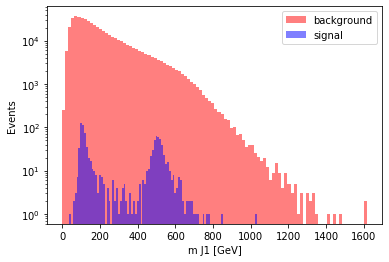

In [14]:
plt.hist(features_bg['mj1'][500000:], bins = 100, fc=(1, 0, 0, 0.5), alpha=0.5, label='background')
plt.hist(features_sig['mj1'][:1000], bins = 100, fc=(0, 0, 1, 0.5), alpha=0.5, label='signal')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel('m J1 [GeV]')
plt.ylabel('Events')
plt.show()

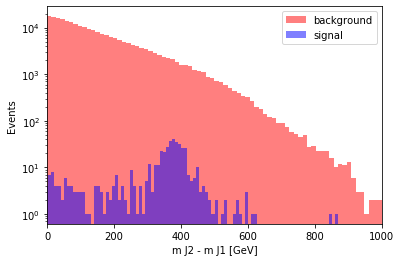

In [15]:
plt.hist((features_bg['mj2'][:500000]-features_bg['mj1'][:500000]), bins = 200, fc=(1, 0, 0, 0.5), alpha=0.5, label='background')
plt.hist((features_sig['mj2'][:1000]-features_sig['mj1'][:1000]), bins = 200, fc=(0, 0, 1, 0.5), alpha=0.5, label='signal')
plt.yscale('log')
plt.xlim(0,1000)
plt.legend(loc='upper right')
plt.xlabel('m J2 - m J1 [GeV]')
plt.ylabel('Events')
plt.show()

# Calculate R(x|m)

### Load the output from the training and exponentiate

In [16]:
pfull_actual = np.load('outer_withsig_epoch_9_Model.par_logPfull_actual.npy')

In [17]:
pbg_actual = np.load('outer_withsig_epoch_9_Model.par_logPbg_actual.npy')

In [18]:
xp_pfull=np.exp(pfull_actual)
xp_pbg=np.exp(pbg_actual)

### Isolate the signal region in the dataset 

In [19]:
dataset_bg[0,0] # First index is the row, second index gives the mJJ element

3.3072193874436437

In [20]:
# Delete all rows of dataset_test_actual where the first element is outside 
# [3.3, 3.7], and save as a new array
sr_dataset = dataset_test_actual[(dataset_test_actual[:,0] >= 3.3) & (dataset_test_actual[:,0] <= 3.7),:]

In [21]:
len(sr_dataset)

60749

In [22]:
sr_dataset_sig = sr_dataset[sr_dataset[:,5] > 0.5,:]
sr_dataset_bg = sr_dataset[sr_dataset[:,5] < 0.5,:]

In [23]:
len(sr_dataset_sig)

381

In [24]:
len(sr_dataset_bg)

60368

### Calculate R for signal and for background 

In [25]:
rx_bg=xp_pfull[0:60368]/xp_pbg[0:60368]

In [26]:
rx_sig=xp_pfull[60368:]/xp_pbg[60368:]

### Plot R for signal events 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


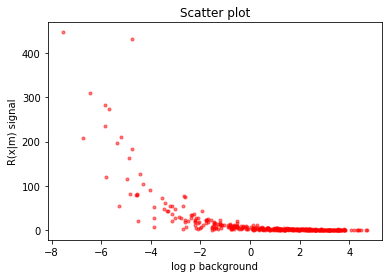

In [27]:
x = pbg_actual[60368:]
y = rx_sig
area = np.pi*3
col = (1,0,0)

# Plot
plt.scatter(x, y, s=area, c=(1,0,0), alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('log p background')
plt.ylabel('R(x|m) signal')
#plt.xlim(-2,5)
#plt.ylim(0,5)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


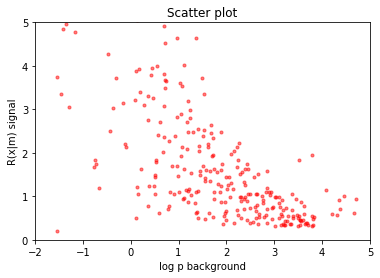

In [28]:
x = pbg_actual[60368:]
y = rx_sig
area = np.pi*3
col = (1,0,0)

# Plot
plt.scatter(x, y, s=area, c=(1,0,0), alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('log p background')
plt.ylabel('R(x|m) signal')
plt.xlim(-2,5)
plt.ylim(0,5)
plt.show()